## What Is the Semi-Supervised GAN?
Semi-supervised learning refers to a problem where a predictive model is required and there are few labeled examples and many unlabeled examples.

The most common example is a classification predictive modeling problem in which there may be a very large dataset of examples, but only a small fraction have target labels. The model must learn from the small set of labeled examples and somehow harness the larger dataset of unlabeled examples in order to generalize to classifying new examples in the future.

The Semi-Supervised GAN, or sometimes SGAN for short, is an extension of the Generative Adversarial Network architecture for addressing semi-supervised learning problems.



The discriminator in a traditional GAN is trained to predict whether a given image is real (from the dataset) or fake (generated), allowing it to learn features from unlabeled images. The discriminator can then be used via transfer learning as a starting point when developing a classifier for the same dataset, allowing the supervised prediction task to benefit from the unsupervised training of the GAN.

In the Semi-Supervised GAN, the discriminator model is updated to predict K+1 classes, where K is the number of classes in the prediction problem and the additional class label is added for a new “fake” class. It involves directly training the discriminator model for both the unsupervised GAN task and the supervised classification task simultaneously.



### As such, the discriminator is trained in two modes: a supervised and unsupervised mode.

**Unsupervised Training:** In the unsupervised mode, the discriminator is trained in the same way as the traditional GAN, to predict whether the example is either real or fake.

**Supervised Training:** In the supervised mode, the discriminator is trained to predict the class label of real examples.
Training in unsupervised mode allows the model to learn useful feature extraction capabilities from a large unlabeled dataset, whereas training in supervised mode allows the model to use the extracted features and apply class labels.

The result is a classifier model that can achieve state-of-the-art results on standard problems such as MNIST when trained on very few labeled examples, such as tens, hundreds, or one thousand. Additionally, the training process can also result in better quality images output by the generator model.

### How to Implement the Semi-Supervised Discriminator Model
There are a number of ways that we can implement the discriminator model for the semi-supervised GAN.

We will two three candidate approaches.

#### Separate Discriminator Models With Shared Weights

Starting with the standard GAN discriminator model, we can update it to create two models that share feature extraction weights.

Specifically, we can define one classifier model that predicts whether an input image is real or fake, and a second classifier model that predicts the class of a given model.

Binary Classifier Model. Predicts whether the image is real or fake, sigmoid activation function in the output layer, and optimized using the binary cross entropy loss function.
Multi-Class Classifier Model. Predicts the class of the image, softmax activation function in the output layer, and optimized using the categorical cross entropy loss function.
Both models have different output layers but share all feature extraction layers. This means that updates to one of the classifier models will impact both models.

The example below creates the traditional discriminator model with binary output first, then re-uses the feature extraction layers and creates a new multi-class prediction model, in this case with 10 classes.


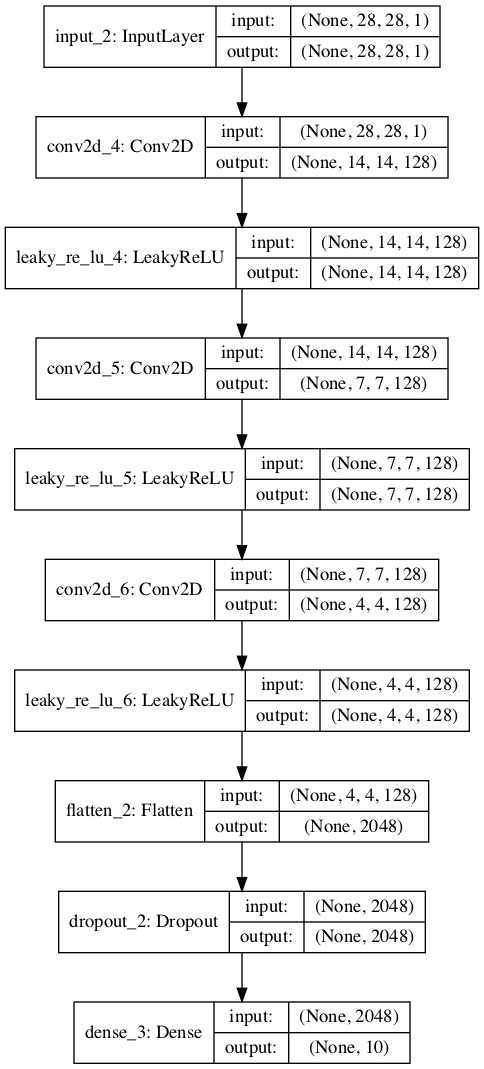

In [2]:
# example of defining semi-supervised discriminator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # image input
    in_image = Input(shape=in_shape)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # unsupervised output
    d_out_layer = Dense(1, activation='sigmoid')(fe)
    # define and compile unsupervised discriminator model
    d_model = Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    # supervised output
    c_out_layer = Dense(n_classes, activation='softmax')(fe)
    # define and compile supervised discriminator model
    c_model = Model(in_image, c_out_layer)
    c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return d_model, c_model

# create model
d_model, c_model = define_discriminator()
# plot the model
plot_model(d_model, to_file='discriminator1_plot.png', show_shapes=True, show_layer_names=True)
plot_model(c_model, to_file='discriminator2_plot.png', show_shapes=True, show_layer_names=True)

### Stacked Discriminator Models With Shared Weights
A final approach is very similar to the prior two approaches and involves creating separate logical unsupervised and supervised models but attempts to reuse the output layers of one model to feed as input into another model.

The approach is based on the definition of the semi-supervised model in the 2016 paper by Tim Salimans, et al. from OpenAI titled “Improved Techniques for Training GANs.”

In the paper, they describe an efficient implementation, where first the supervised model is created with K output classes and a softmax activation function. The unsupervised model is then defined that takes the output of the supervised model prior to the softmax activation, then calculates a normalized sum of the exponential outputs.

To make this clearer, we can implement this activation function in NumPy and run some sample activations through it to see what happens.



In [3]:
# example of custom activation function
import numpy as np

# custom activation function
def custom_activation(output):
    logexpsum = np.sum(np.exp(output))
    result = logexpsum / (logexpsum + 1.0)
    return result

# all -10s
output = np.asarray([-10.0, -10.0, -10.0])
print(custom_activation(output))
# all -1s
output = np.asarray([-1.0, -1.0, -1.0])
print(custom_activation(output))
# all 0s
output = np.asarray([0.0, 0.0, 0.0])
print(custom_activation(output))
# all 1s
output = np.asarray([1.0, 1.0, 1.0])
print(custom_activation(output))
# all 10s
output = np.asarray([10.0, 10.0, 10.0])
print(custom_activation(output))

0.00013618124143106674
0.5246331135813284
0.75
0.890768227426964
0.9999848669190928


Remember, the output of the unsupervised model prior to the softmax activation function will be the activations of the nodes directly. They will be small positive or negative values, but not normalized, as this would be performed by the softmax activation.


The custom activation function will output a value between 0.0 and 1.0.

A value close to 0.0 is output for a small or negative activation and a value close to 1.0 for a positive or large activation. We can see this when we run the example.

This means that the model is encouraged to output a strong class prediction for real examples, and a small class prediction or low activation for fake examples. It’s a clever trick and allows the re-use of the same output nodes from the supervised model in both models.

The activation function can be implemented almost directly via the Keras backend and called from a Lambda layer, e.g. a layer that will apply a custom function to the input to the layer.

The complete example is listed below. First, the supervised model is defined with a softmax activation and categorical cross entropy loss function. The unsupervised model is stacked on top of the output layer of the supervised model before the softmax activation, and the activations of the nodes pass through our custom activation function via the Lambda layer.

No need for a sigmoid activation function as we have already normalized the activation. As before, the unsupervised model is fit using binary cross entropy loss.

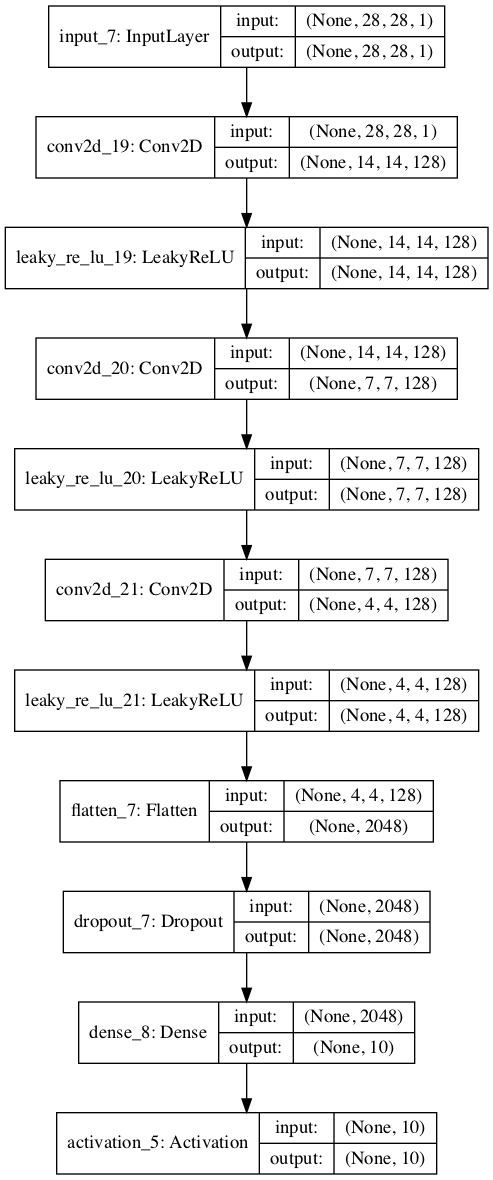

In [9]:
# example of defining semi-supervised discriminator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Lambda
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend

# custom activation function
def custom_activation(output):
    logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape) 
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    fe = Dense(n_classes)(fe)
    c_out_layer = Activation('softmax')(fe)
    c_model = Model(in_image, c_out_layer)
    c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'] )
    d_out_layer = Lambda(custom_activation)(fe)
    d_model = Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model

d_model, c_model = define_discriminator()
plot_model(d_model, to_file='stacked_discriminator1_plot.png', show_shapes=True, show_layer_names=True)
plot_model(c_model, to_file='stacked_discriminator2_plot.png', show_shapes=True, show_layer_names=True)
